# Сделайте генератор лиц аниме на основе Anime Faces

In [1]:
import kagglehub

In [2]:
path = kagglehub.dataset_download("soumikrakshit/anime-faces")

In [3]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [4]:
image_size = 64
batch_size = 1024
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [5]:
train_ds = ImageFolder(path, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [6]:
from torch.utils.data import DataLoader

In [7]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [8]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

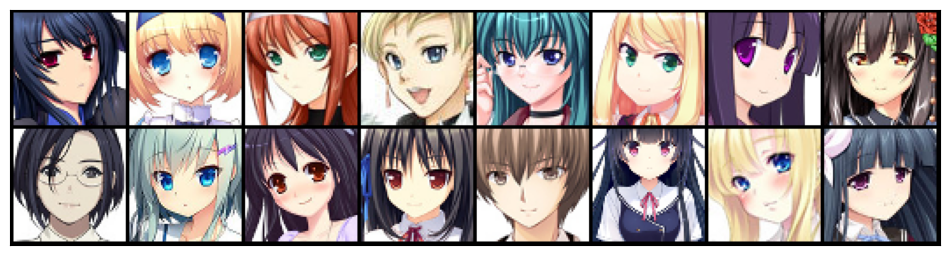

In [10]:
show_batch(train_dl, 16)

In [11]:
import torch
from torch import nn
import torchvision as tv
import time

In [12]:
class Generator(nn.Module):
    def __init__(self, initial_size):
        super().__init__()
        self.model = nn.Sequential(
            # in: latent_size x 1 x 1
        
            nn.ConvTranspose2d(initial_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # out: 512 x 4 x 4
        
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # out: 256 x 8 x 8
        
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # out: 128 x 16 x 16
        
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # out: 64 x 32 x 32
        
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # out: 3 x 64 x 64
        )
    def forward(self, xb):
        return self.model(xb)
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        # in: 3 x 64 x 64
    
        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 64 x 32 x 32
    
        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 128 x 16 x 16
    
        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 256 x 8 x 8
    
        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),
        # out: 512 x 4 x 4
    
        nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
        # out: 1 x 1 x 1
    
        nn.Flatten(),
        nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [13]:
dev = torch.device('cuda')

In [14]:
initial_size = 100 #длина вектора для генерации изображения

G = Generator(initial_size = initial_size).to(dev)
D = Discriminator().to(dev)

In [15]:
import torch.nn.functional as F

In [16]:
# loss
criterion = nn.BCELoss()
#criterion = F.binary_cross_entropy
# optimizer
lr = 0.0001
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas=(0.5, 0.999))

In [17]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.to(dev), torch.ones(batch_size, 1, device = dev)
#    x_real, y_real = torch.autograd.Variable(x_real.to(dev)), torch.autograd.Variable(y_real.to(dev))

    D_output = D(x_real).to(dev)
    D_real_loss = criterion(D_output, y_real)
    
    # train discriminator on facke
    z = torch.randn(batch_size, initial_size, 1, 1, device = dev)
    x_fake, y_fake = G(z).to(dev), torch.zeros(batch_size, 1, device = dev)

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    
    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.item()

In [18]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.randn(batch_size, initial_size, 1, 1).to(dev)
    y = torch.ones(batch_size,1 ).to(dev)

    G_output = G(z).to(dev)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.item()

In [19]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_dl):
        if len(x) != batch_size:
          continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))
    if epoch%10 == 0:
        print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[10/100]: loss_d: 0.655, loss_g: 4.143
[20/100]: loss_d: 0.582, loss_g: 4.297
[30/100]: loss_d: 0.566, loss_g: 4.430
[40/100]: loss_d: 0.373, loss_g: 4.553
[50/100]: loss_d: 0.391, loss_g: 5.075
[60/100]: loss_d: 0.334, loss_g: 5.361
[70/100]: loss_d: 0.292, loss_g: 4.870
[80/100]: loss_d: 0.402, loss_g: 4.602
[90/100]: loss_d: 0.327, loss_g: 4.081
[100/100]: loss_d: 0.338, loss_g: 3.510


In [27]:
with torch.no_grad():
    test_z = torch.randn(16, initial_size, 1, 1).to(dev)
    generated = G(test_z)

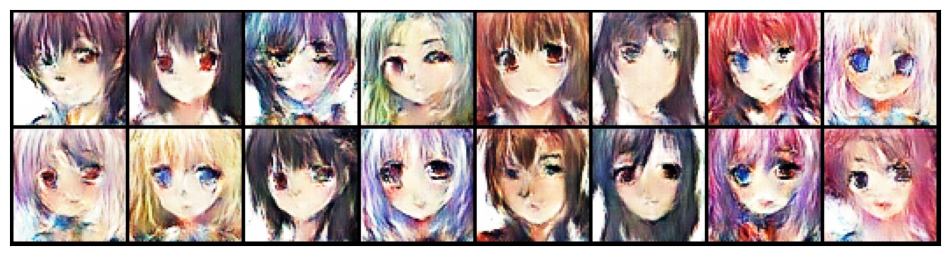

In [28]:
show_images(generated.cpu(), 16)